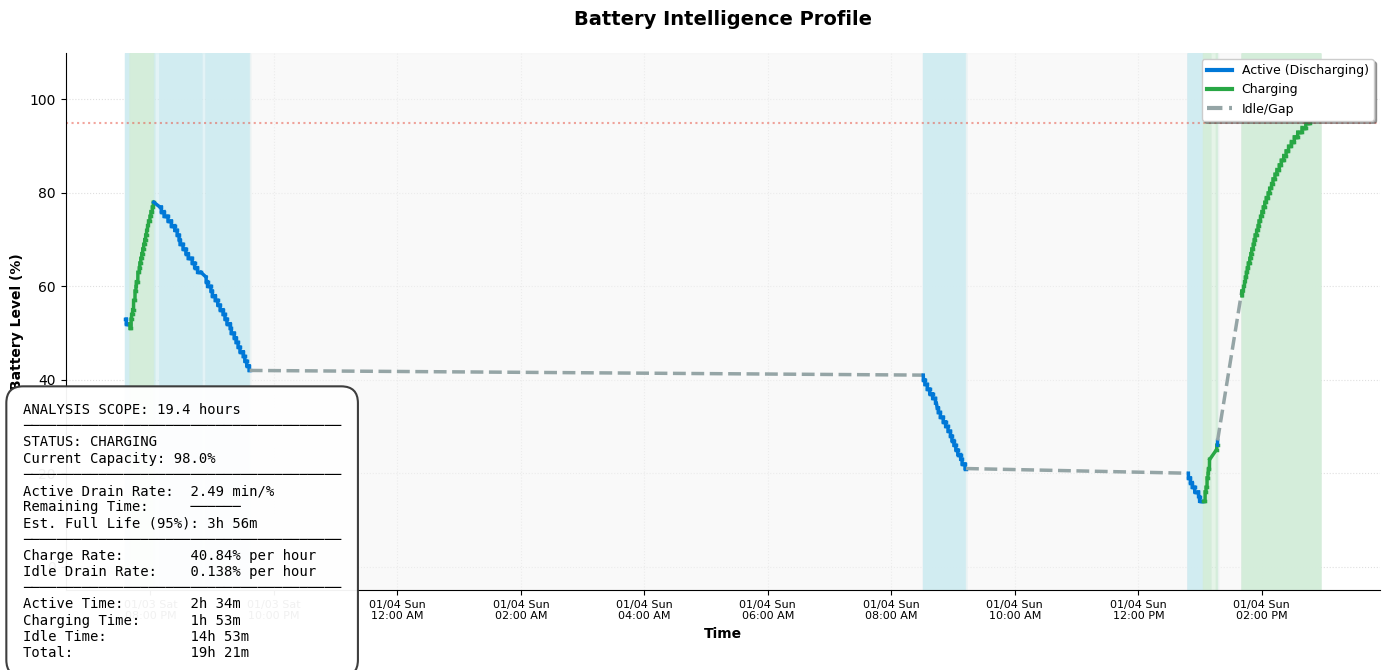

KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd  # MISSING IMPORT
from pathlib import Path
import time
from IPython.display import display, clear_output
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# --- CONFIGURATION ---
FILE_PATH = Path.home() / "Desktop" / "battery_logger" / "battery_log.csv"
IDLE_THRESHOLD_MINS = 10 
REFERENCE_PCT = 95

def format_time(total_mins):
    if total_mins <= 0 or np.isnan(total_mins):
        return "0h 0m"
    h = int(total_mins // 60)
    m = int(total_mins % 60)
    return f"{h}h {m}m"

while True:
    if FILE_PATH.exists():
        try:
            with open(FILE_PATH, 'r', encoding='utf-8', errors='ignore') as f:
                df = pd.read_csv(f, header=None, names=['A', 'B', 'C'])

            if not df.empty and len(df) > 1:
                # 1. Data Processing
                df['Timestamp'] = pd.to_datetime(df['A'], errors='coerce')
                df['Percentage'] = df['B'].astype(str).str.replace('%', '').astype(float)
                df['Charger'] = df['C'].astype(str).str.strip()
                df = df.dropna(subset=['Timestamp', 'Percentage']).sort_values('Timestamp')

                df['time_delta'] = df['Timestamp'].diff().dt.total_seconds() / 60
                df['pct_delta'] = df['Percentage'].shift(1) - df['Percentage']
                
                # Calculate Total Time Scope
                time_span = df['Timestamp'].max() - df['Timestamp'].min()
                total_hours_analyzed = time_span.total_seconds() / 3600

                # 2. Refined Calculations
                # First, identify charging periods to exclude them entirely
                charging_mask = (df['Charger'] == 'Yes')
                df['is_charging'] = charging_mask
                
                # Calculate time spent in each state
                # Priority order: idle (big gaps) > charging > active
                # This ensures every time period is categorized exactly once
                
                idle_mask = (df['time_delta'] > IDLE_THRESHOLD_MINS) & (df['time_delta'].notna())
                
                charge_mask = (~idle_mask) & \
                             (df['Charger'] == 'Yes') & \
                             (df['time_delta'] > 0) & \
                             (df['time_delta'].notna())
                
                active_mask = (~idle_mask) & \
                             (~charge_mask) & \
                             (df['time_delta'] > 0) & \
                             (df['time_delta'].notna())
                
                # Sum all time_delta for each category
                total_active_mins = df.loc[active_mask, 'time_delta'].sum()
                total_charge_mins = df.loc[charge_mask, 'time_delta'].sum()
                total_idle_mins = df.loc[idle_mask, 'time_delta'].sum()
                
                # This should now equal total_hours_analyzed
                total_measured_mins = total_active_mins + total_charge_mins + total_idle_mins
                
                # Calculate battery changes during each period
                # Active periods: sum ALL battery change (positive = drain, negative = gain)
                total_active_drop = df.loc[active_mask, 'pct_delta'].sum()
                
                # Charging periods: sum battery gain (pct_delta is negative when charging)
                total_charge_gain = -df.loc[charge_mask, 'pct_delta'].sum()
                
                # Idle periods: only count when battery actually drained (pct_delta > 0)
                idle_drain_mask = idle_mask & (df['pct_delta'] > 0)
                total_idle_drop = df.loc[idle_drain_mask, 'pct_delta'].sum()
                total_idle_drain_mins = df.loc[idle_drain_mask, 'time_delta'].sum()

                # RATE CALCULATIONS
                # Active drain rate: minutes to drain 1% during active use
                # Uses ALL active time, not just when battery dropped
                active_rate = total_active_mins / total_active_drop if total_active_drop > 0 else 0
                
                # Charge rate: % gained per hour while plugged in
                # Uses ALL charging time
                charge_rate_hr = (total_charge_gain / total_charge_mins * 60) if total_charge_mins > 0 else 0
                
                # Idle drain rate: % lost per hour during idle/sleep (only actual drain periods)
                avg_idle_loss_per_hr = (total_idle_drop / total_idle_drain_mins * 60) if total_idle_drain_mins > 0 else 0

                current_pct = df['Percentage'].iloc[-1]
                is_charging = df['Charger'].iloc[-1] == 'Yes'
                
                # Estimates
                endurance_ref_mins = active_rate * REFERENCE_PCT
                current_rem_mins = active_rate * current_pct if not is_charging else 0

                # 3. Plotting logic - Enhanced UI
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(14, 7))
                
                for i in range(1, len(df)):
                    p1, p2 = df.iloc[i-1], df.iloc[i]
                    start_t, end_t = p1['Timestamp'], p2['Timestamp']
                    
                    if p2['time_delta'] > IDLE_THRESHOLD_MINS:
                        bg_color, line_color, line_style = '#f5f5f5', '#95a5a6', '--'
                    elif p2['Charger'] == 'Yes':
                        bg_color, line_color, line_style = '#d4edda', '#28a745', '-'
                    else:
                        bg_color, line_color, line_style = '#d1ecf1', '#0078d7', '-'

                    ax.axvspan(start_t, end_t, color=bg_color, alpha=0.6)
                    ax.plot([start_t, end_t], [p1['Percentage'], p2['Percentage']], 
                            color=line_color, linestyle=line_style, linewidth=2.5)

                # Legend with better styling
                custom_lines = [
                    Line2D([0], [0], color='#0078d7', lw=3),
                    Line2D([0], [0], color='#28a745', lw=3),
                    Line2D([0], [0], color='#95a5a6', lw=3, linestyle='--')
                ]
                ax.legend(custom_lines, ['Active (Discharging)', 'Charging', 'Idle/Gap'], 
                          loc='upper right', fontsize=9, frameon=True, fancybox=True, shadow=True)

                # Dashboard Text - Improved layout and formatting
                status_color = '#28a745' if is_charging else '#dc3545'
                status_text = 'CHARGING' if is_charging else 'DISCHARGING'
                
                stats_text = (
                    f"ANALYSIS SCOPE: {total_hours_analyzed:.1f} hours\n"
                    f"{'─' * 38}\n"
                    f"STATUS: {status_text}\n"
                    f"Current Capacity: {current_pct:.1f}%\n"
                    f"{'─' * 38}\n"
                    f"Active Drain Rate:  {active_rate:.2f} min/%\n"
                    f"Remaining Time:     {format_time(current_rem_mins) if not is_charging else '──────'}\n"
                    f"Est. Full Life ({REFERENCE_PCT}%): {format_time(endurance_ref_mins)}\n"
                    f"{'─' * 38}\n"
                    f"Charge Rate:        {charge_rate_hr:.2f}% per hour\n"
                    f"Idle Drain Rate:    {avg_idle_loss_per_hr:.3f}% per hour\n"
                    f"{'─' * 38}\n"
                    f"Active Time:        {format_time(total_active_mins)}\n"
                    f"Charging Time:      {format_time(total_charge_mins)}\n"
                    f"Idle Time:          {format_time(total_idle_mins)}\n"
                    f"Total:              {format_time(total_measured_mins)}"
                )
                
                fig.text(0.02, 0.05, stats_text, fontsize=10, family='monospace',
                         bbox=dict(facecolor='white', alpha=0.95, edgecolor='#333', 
                                  boxstyle='round,pad=1.2', linewidth=1.5),
                         verticalalignment='bottom')

                # Reference line with label
                ax.axhline(REFERENCE_PCT, color='#e74c3c', linestyle=':', linewidth=1.5, alpha=0.5, label=f'{REFERENCE_PCT}% Reference')
                
                # X-Axis Formatting - Cleaner date labels
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %a\n%I:%M %p'))
                plt.xticks(rotation=0, ha='center', fontsize=8)
                
                # Y-Axis improvements
                ax.set_ylim(-5, 110)
                ax.set_ylabel('Battery Level (%)', fontsize=10, fontweight='bold')
                ax.set_xlabel('Time', fontsize=10, fontweight='bold')
                
                ax.set_title("Battery Intelligence Profile", fontsize=14, fontweight='bold', pad=20)
                ax.grid(True, which='major', linestyle=':', alpha=0.4, linewidth=0.8)
                ax.grid(True, which='minor', linestyle=':', alpha=0.2, linewidth=0.5)
                
                # Styling
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_axisbelow(True)
                
                plt.tight_layout()
                plt.subplots_adjust(bottom=0.15)
                plt.show()

        except Exception as e:
            print(f"Update Loop Error: {e}")
            time.sleep(5)
    
    time.sleep(10)